# Body Fat Data Analysis
#### Group members:Yan Chu, Boliang Ma, Jiacheng Xu

The goal is to come up with a simple, robust, accurate and precise  “rule-of-thumb” method to estimate percentage of body fat based on the data set.

The data set contains measurements from 252 men who had their body fat percentage accurately measured via underwater weighing.

## Step 1: Analyzing Raw Data

In [2]:
options(warn = -1)#igonre warnings
library(repr); library(car); library(ggplot2); suppressMessages(library(tidyverse))
body <- read.csv("data/BodyFat.csv",header = T)# read data
body_fit <- body[,c(-1,-3)]
matrix(c(min(body$BODYFAT),max(body$BODYFAT),min(body$WEIGHT),max(body$WEIGHT),min(body$HEIGHT),max(body$HEIGHT)),
       ncol = 3,nrow =2,dimnames = list(c("min","max"),c("Bodyfat","Weight","Height")))

,Bodyfat,Weight,Height
min,0.0,118.50,29.50
max,45.1,363.15,77.75


Frist, we look at raw data summary. The table shows the min-max value of bodyfat, weight and height. We notice that the minimum value of bodyfat is 0, maximum weight is more than 360 pounds, minimum height is 29.50, which may be potential outliers in the future fitting.
We notice that the oldest man is already 81 years old, whose data may be not that normal compared to younger people, which we need to be careful in model fitting. 
The distribution of bodyfat with different age group is different, further, we find that WHO (World Health Organization) define people under 45 years old as youth. It is worthy thinking about there may have different criteria to calculate body fat between the youth and the old. 

## Step 2: Visualizing Data
The plot shows the distribution of some variables which we consider may use in the future in the data set.

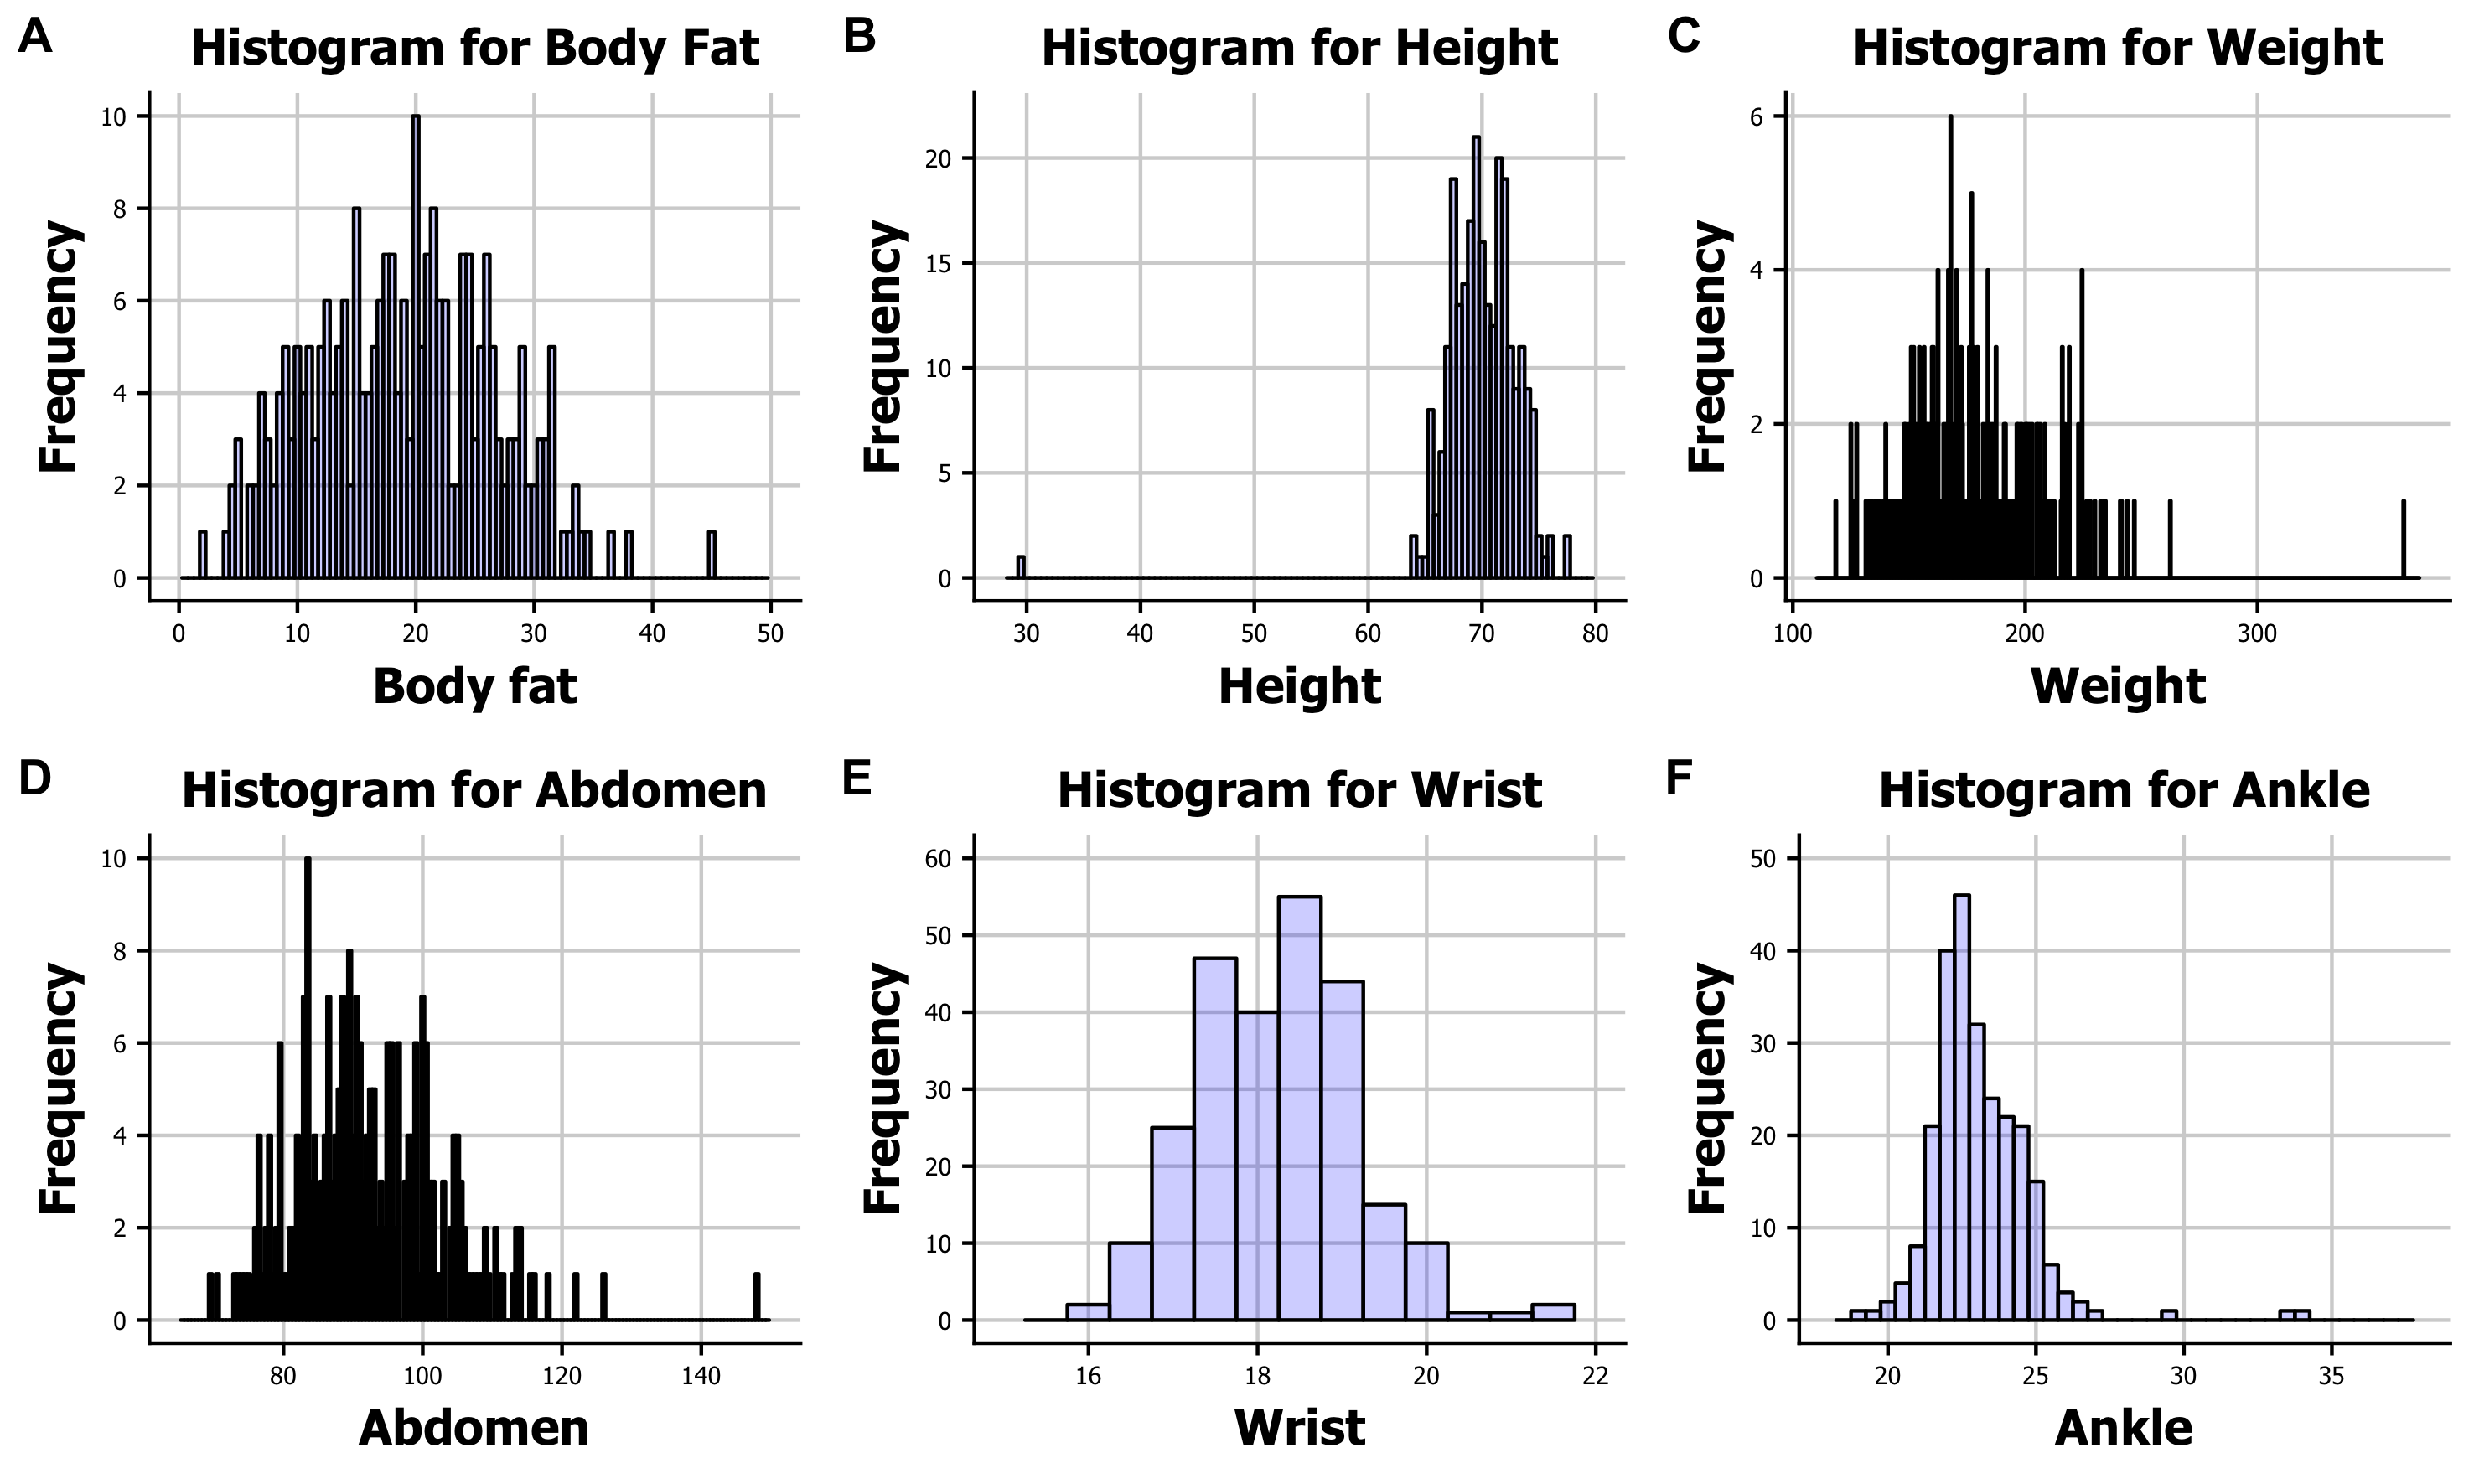

In [4]:
library("IRdisplay")
display_png(file="Plots/hist_for_all.png")

The plot shows the relation of bodyfat with different variables in the data set.

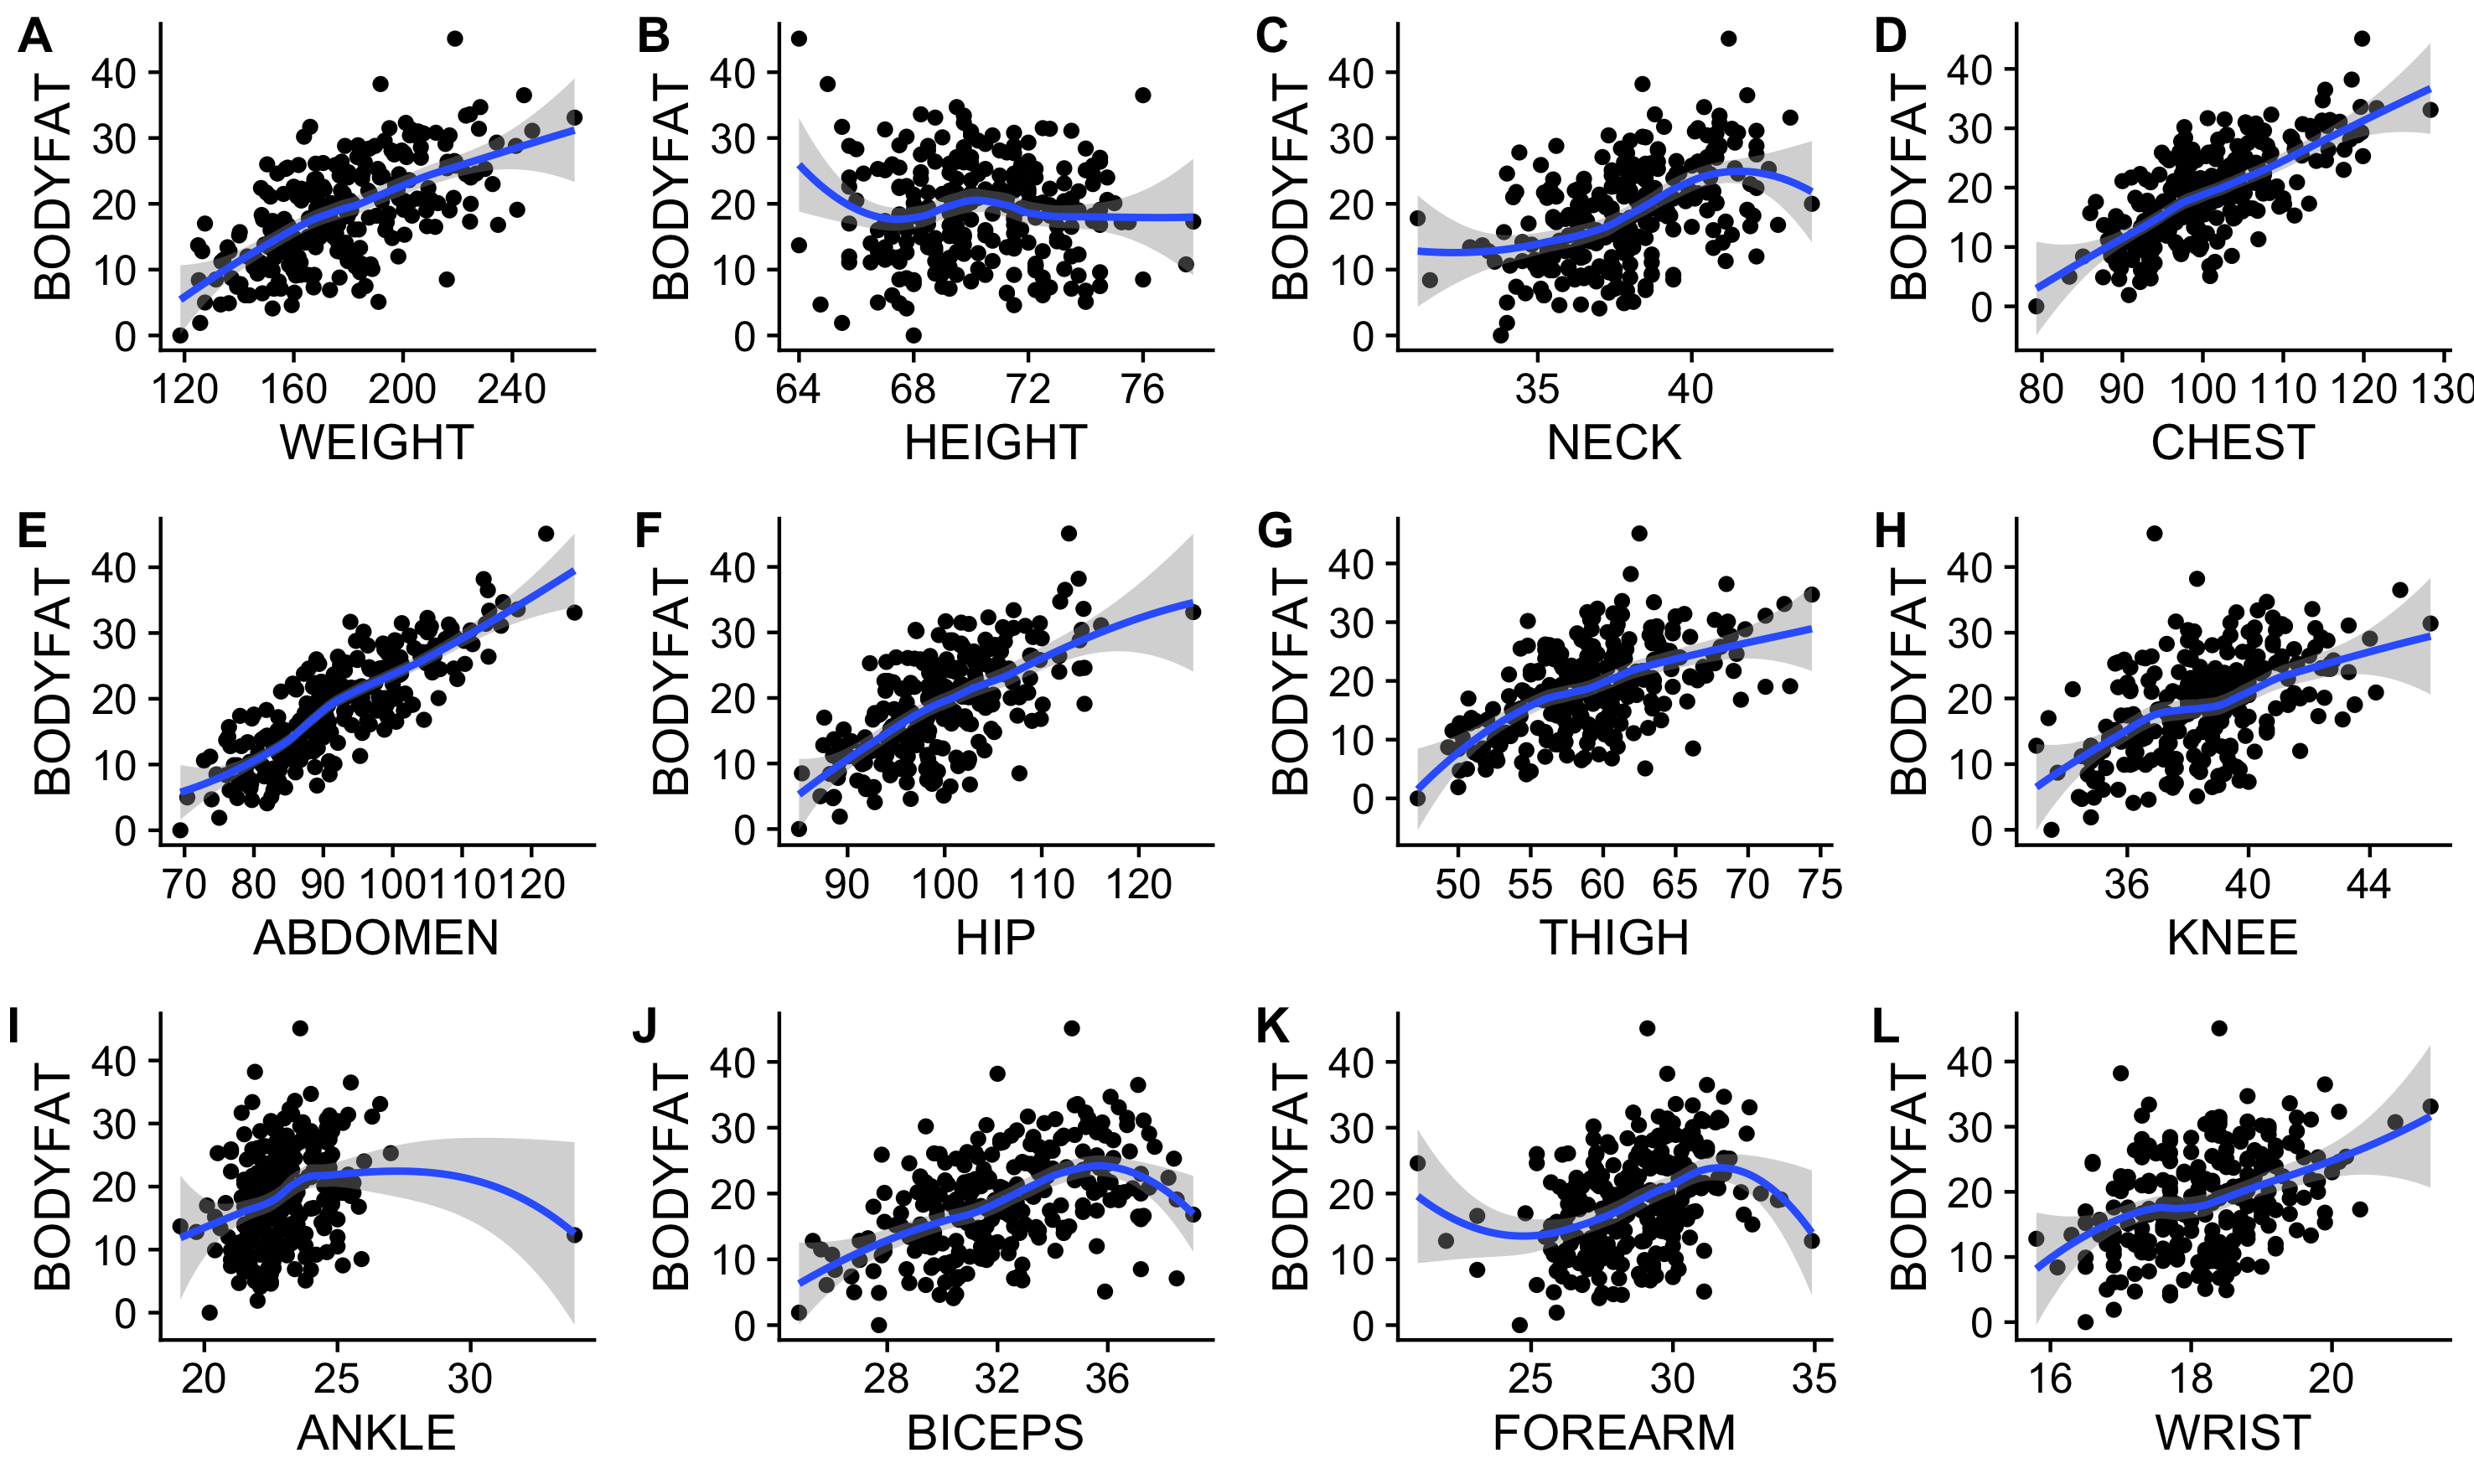

In [5]:
display_png(file="Plots/ggpairs.png")

The plots shows the relation between bodyfat and age, from this plot we can see that there is a trend change within the different age group and we plot the rough threshold on age 45.

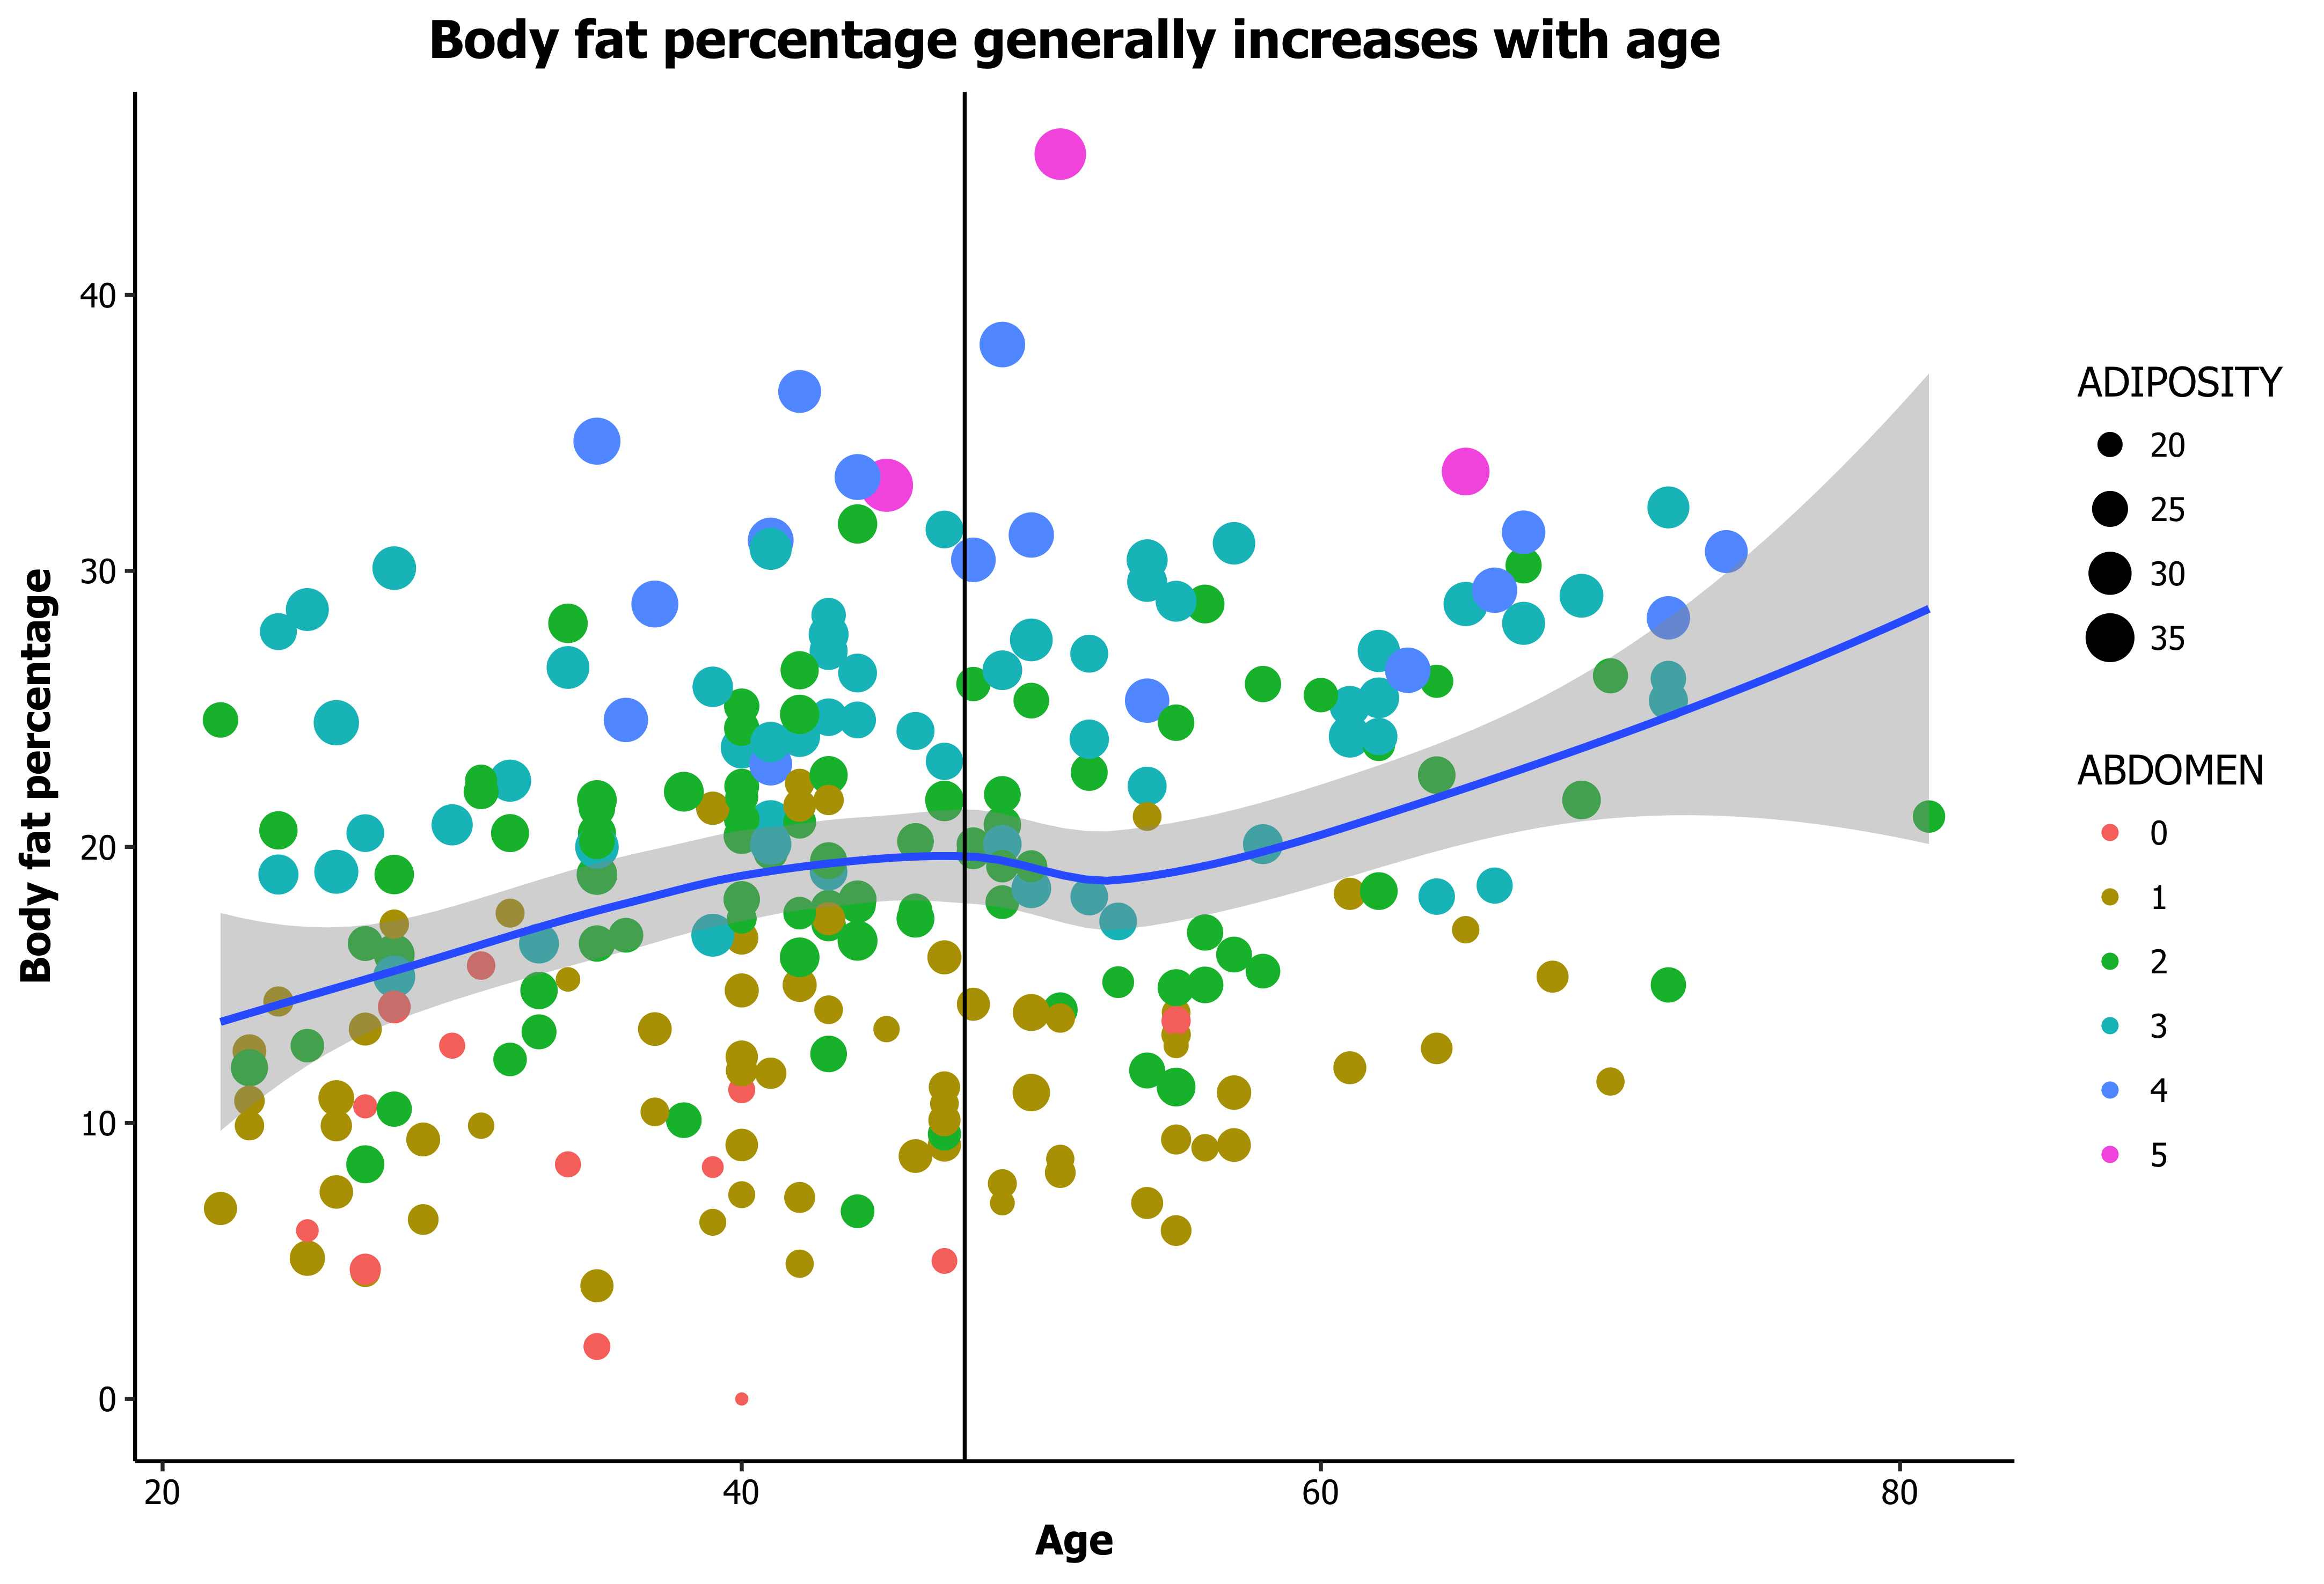

In [6]:
display_png(file="Plots/bodyfat_vs_age.png")

## Step 3: Statistical Modeling and Analysis
### (1) Full data set

First, perform test and regression on full data set.
We first do naive regression for outliers detection and data cleaning. Based on Cook's distance, we find that point 39, 42, 221, 86 are high influential point, delete them and get the completed regression model. We can see that the fattest man and the shortest man has been out of model.

In [11]:
model5 <- lm(BODYFAT~., data = body_fit[c(-42,-39,-221,-86),]) ##Clean up completed.

We perform AIC forward and backward regression to select variables. The results are showed in the following table. Since we want a simple, robust, accurate and precise “rule-of-thumb” method, and forward method has similar MSE with backward method but has less variables. So, we based on forward selection, delete 3 variables (forearm, thigh and age) which have relatively less importance scores, also can reduce multicollinearity. So, abdomen, weight and wrist will be the three variables in our final model for full data set.

|Method | Variable | MSE|
|:------ | :-------- | :---|
|Forward | Abdomen, Weight, Wrist, Forearm, Thigh, Age | 14.74|
|Backward | Age, Weight, Height, Adiposity, Abdomen, Thigh, Forearm, Wrist | 14.55|

In [12]:
### Based on forward selection, further delete 3 variables for adjust multicollinearity
full_final <- lm(BODYFAT~ABDOMEN+WEIGHT+WRIST,body_fit[c(-42, -39, -221, -86),])

Then, we divide data into two groups using 45 years old as dividing line. 

### (2). Age under 45 years old

For data that age under 45, we do the same procedure again, do naive regression and clean data. Points 42, 31, and 163 are deleted.
We perform AIC forward, backward and stepwise regression to select variables. We got 3 models, but all of them show very high multicollinearity, which is not good.

In [16]:
model45_4 <- lm(BODYFAT~., data = body_45[(body_45$IDNO!=42&body_45$IDNO!=31&body_45$IDNO!=163),c(-1,-3)])

| Variable | Age | Weight | Height | Adiposity |Neck|Chest|Abdomen|Hip|Thigh|Knee|Ankle|Biceps|Forearm|Wrist|
|:----------|:---|:-------|:-------|:----------|:----|:---|:------|:---|:---|:---|:----|:-----|:------|:-----|
|VIF Value | 1.41|339.28|60.88|252.94|4.56|10.70|14.07|18.42|9.82|5.26|4.07|5.36|2.05|4.39|

Then we remove adiposity based on analysis that abdomen has high correlation with adiposity. We clean data again. Delete point 31 and 42. After delete these two points, we use AIC forward, backward and stepwise to select variables. Although forward selection is good in terms of MSE, model is too complex. So, we choose backward selection, delete age since importance score is lowest. Then we have weight, abdomen, wrist, biceps and ankle as predict variables in final model for people under 45 years old.

In [17]:
### Although forward selection is good in terms of mse, model is too complex, choose back selection, and delete age
under_45_final <- lm(BODYFAT~WEIGHT+ABDOMEN+WRIST+BICEPS+ANKLE,body_45[(body_45$IDNO!=31&body_45$IDNO!=42),c(-1,-3,-7)])

### (3). Age beyond 45 years old

Then we deploy same procedure on old group. Based on the model we get, we have #39, #86, #221 as high influential point. We delete those data points and do variable selection. We still perform AIC forward, backward regression to select variables. Both methods suggest the same model, it’s simple, predictive and there isn’t obvious multicollinearity. So, in our final model for people beyond 45 years old, we have abdomen and weight as predict variables.

In [18]:
body45_up <- body[body$AGE>45,]
model45_up4 <- lm(BODYFAT~.,data = body45_up[(body45_up$IDNO!=39&body45_up$IDNO!=86&body45_up$IDNO!=221),c(-1,-3)]) ##Clean up completed.

In [19]:
#### model is simple, predictive and multicollinearity issue is solved
up_45_final <- lm(BODYFAT~ABDOMEN+WEIGHT,body45_up[(body45_up$IDNO!=39&body45_up$IDNO!=86&body45_up$IDNO!=221),c(-1,-3)])

## Step 4: Model Diagnostics

For model diagnostic part, we did assumption test and plot the model fitting plot. The following table shows us all the three models- full data model, divided model with age, are good in terms of Gaussian assumption. Besides, we calculate mean square error with the full data model and combined age-division model. The result shows that there is a improvment in accuracy by fitting with different age group.  

|Assumption (Method) \ Model|Full data Model|Under 45 years old|Beyond 45 years old|
|:---------------|:--------------|:-----------------|:------------------|
|Linearity (crPlot)|Pass|Pass|Pass|
|Homoscedasticity (ncvTest)|Pass (p-value = 0.51)|Pass (p-value = 0.13)|Pass (p-value = 0.47)|
|Normality (QQplot)|Pass|Pass|Pass|
|Independence (DWtest)|Pass (p-value = 0.08)|Pass (p-value = 0.42)|Pass (p-value = 0.87)|

|  |Full data model| Combined model|
|:-|:-------------|:---------|
|MSE|15.32|14.44|

## Step 5: Conclusions

The model we proposed is following formula: Note that the weight is measured in pounds and others are in centimeters(cm).

$$BodyFat\ \% = \begin{cases}
-28.927\ +\ 0.920ABDOMEN\ -\ 0.150WEIGHT\ -\ 2.498WRIST\ +\ 0.565BICEPS\ +\ 0.723ANKLE,\ if\ AGE\ \leq\ 45 \\
-46.224\ +\ 0.919ABDOMEN\ -\ 0.112WEIGHT,\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \  \ \  \ \ \ \ \ \   if\ AGE\ >\ 45
\end{cases}$$

**Possible rule of thumb:** 
If you are under 45, measure your abdomen circumference, weight, wrist circumference, biceps circumference and ankle circumference, use the formula below:$$BodyFat\ \% = -30\ +\ ABDOMEN\ -\ 0.1WEIGHT\ -\ 2.5WRIST\ +\ 0.5BICEPS\ +\ ANKLE$$
If you are over 45, measure your abdomen circumference and weight, use the formula below:
$$BodyFat\ \% = -46\ +\ ABDOMEN\ -\ 0.1WEIGHT$$


**Inference about Relationship:** The linear relation is significant at 0.05 level in both age group and both model explain more than 73% of the bodyfat.

**Strengths and Weakness:** We think it is a reasonable model with high explanatory ability

1. All assumptions are well satisfied.
2. No advanced techniques for dealing with multicollinearity is employed since we just delete the most correlated variables. Maybe we can focus this part in the further work.
3. Due to data contraints, our model is unable to predict bodyfat percentage for children or even more older people.
4. We can only predict male's bodyfat.

Overall, our model is a simple, robust, accruate model for predicting bodyfat percentage for normal people aged between 20 and 80.

### Duties:
1. Yan Chu: Making plots.
2. Boliang Ma: Coding for model build.
3. Jiacheng Xu: Jupyter notebook summary.

### Reference:
1.http://blog.minitab.com/blog/understanding-statistics/handling-multicollinearity-in-regression-analysis
2.https://cran.r-project.org/web/packages/robust/robust.pdf
3.http://www.who.int/ageing/publications/global_health.pdf